In [1]:
from scipy.sparse import csr_matrix
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

from quantumScarsCheck import *
from quantumScarsPlotting import *
from quantumScarFunctions import *

N = 16 # <-----------------------------------------------------------------------------------------------------------------------------
basisList = binNoConsecOnesEfficient(N)
basisMap = {bitStr: i for i, bitStr in enumerate(basisList)}
basisLen = len(basisList)
flippedList = []
omega = 1.0

rowBare = []
columnBare = []

rowFactor = []
columnFactor = []

# flip bit hashmap
flipMap = {'0': '1', '1': '0'}

# sigma z op hashmap
sigzMap = {'0': '-1', '1': '1', '2': '0'}

# list of ints for Hamiltonian
numList = []

# -------------------------------
#
# create the bare PXP hamiltonian
#
# -------------------------------

for i in range(basisLen):

    # add padding so that search doesnt go out of range
    paddedBitStr = '0' + basisList[i] + '0'
    copyBit = list(paddedBitStr)

    # apply the sum of r P_r-1 * sigma_x * P_r+1 operator
    for j in range(1, N+1):
        
        if paddedBitStr[j-1] == '0' and paddedBitStr[j+1] == '0':
            copyBit[j] = flipMap[paddedBitStr[j]]
            flippedList.append(''.join(copyBit)[1:-1])
            copyBit = list(paddedBitStr)
        
    # adds row and column values for the sparse matrix
    for k in range(len(flippedList)):
        
        rowBare.append(basisMap[flippedList[k]])
        columnBare.append(i)
        
    flippedList.clear()

# -------------------------------
#
# create the sigma Z PXP hamiltonian
#
# -------------------------------

# print(basisList)
# print()

for i in range(basisLen):

    # add padding so that search doesnt go out of range
    paddedBitStr = '22' + basisList[i] + '22'
    copyBit = list(paddedBitStr)
    factor = 1

    # apply the PXP operator
    for j in range(2, N+2):
        
        if (paddedBitStr[j-1] == '0' or paddedBitStr[j-1] == '2') and (paddedBitStr[j+1] == '0' or paddedBitStr[j+1] == '2'):
            copyBit[j] = flipMap[paddedBitStr[j]]

            # apply sigmaZ_r-2 + sigmaZ_r+2
            r_neg2 = int(sigzMap[paddedBitStr[j-2]])
            r_pos2 = int(sigzMap[paddedBitStr[j+2]])
            factor = r_neg2 + r_pos2
            numList.append(factor)

            flippedList.append(''.join(copyBit)[2:-2])
            copyBit = list(paddedBitStr)
        
    # print(flippedList)

    # adds row and column values for the sparse matrix
    for k in range(len(flippedList)):
        
        rowFactor.append(basisMap[flippedList[k]])
        columnFactor.append(i)
        
    flippedList.clear()

# list of ones for the sparse matrix
onesList = np.ones(len(rowBare), dtype=int)

# create the sparse matrix and turn it into a Qobj
sparseBareHamiltonian = csr_matrix((onesList, (rowBare, columnBare)), shape=[basisLen, basisLen])
matrixBareHamiltonian = sparseBareHamiltonian.toarray()

sparseFactoredHamiltonian = csr_matrix((numList, (rowFactor, columnFactor)), shape=[basisLen, basisLen])
matrixFactoredHamiltonian = sparseFactoredHamiltonian.toarray()

H0 = (omega / 2 * sparseBareHamiltonian) + (-0.026 * sparseFactoredHamiltonian)

# print()
# print(H0)

H0 = qt.Qobj(H0)

# -------------------------------
#
# states and evolutions set ups
#
# -------------------------------

# diagonalize the sparse matrix
eigenvalues, eigenstates = H0.eigenstates()

# initial state
z2_str = z2_initial(N)
z2_index = basisMap[z2_str]
psi0 = qt.basis(basisLen, z2_index)

# time evolution of sparse matrix
tlist = np.linspace(0, 400, 500)
evolState = qt.sesolve(H0, psi0, tlist)

# -------------------------------
#
# create the driving hamiltonian
#
# -------------------------------

# create H1 operator for QobjEvo!
copyBasis = basisList
diagH1 = []

# switches 0s to -1s and keeps 1s the same for the copyBasis
# appends to diagH1 the dot product between each bit string and the 0 -> -1 Z2 state
for i in range(basisLen):

    bitString = list(copyBasis[i])
    bitString = [int(i) for i in bitString]

    z2bitString = list(z2_initial(N))
    z2bitString = 2 * np.array([int(i) for i in z2bitString]) - 1

    diagH1.append(np.dot(2 * np.array(bitString) - 1, z2bitString))

# rows and columns lists for diagonal positions in H1
rowH1 = [i for i in range(basisLen)]
columnH1 = [i for i in range(basisLen)]

# creates sparse matrix with diagonals as diagH1 list
H1 = csr_matrix((diagH1, (rowH1, columnH1)), shape=[basisLen, basisLen])
H1 = qt.Qobj(H1)


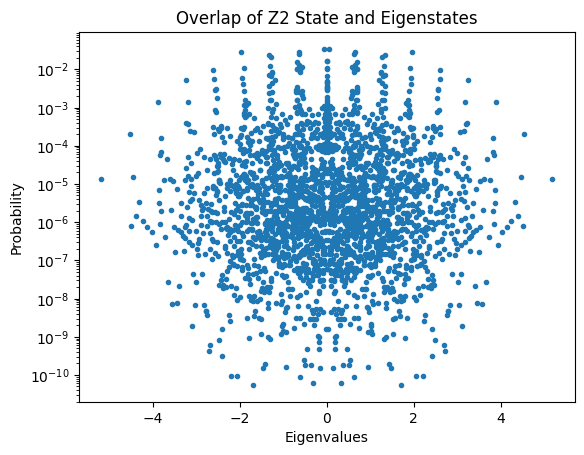

In [3]:
plotAmpEigenstatesZ2Log(H0, psi0)

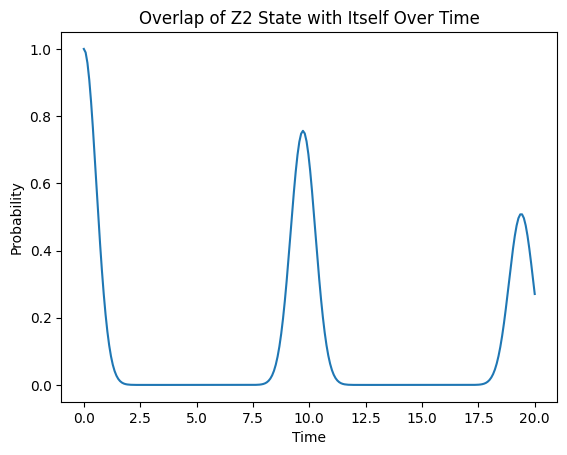

In [47]:
plotProbZ2Time(H0, psi0)

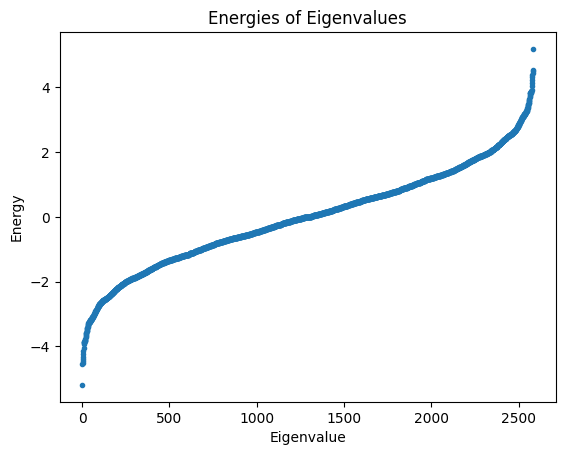

In [48]:
plotEigEnergies(H0)